# Cusp Distribution
This notebook shows how to sample the distribution of cusps. Most of the relevant code is in the file cusp_encounters.cusp_distribution which is based on the peak statistics of a Gaussian random field. All of this is explained by [Delos & White (2022)](https://arxiv.org/abs/2209.11237)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../adiabatic-tides")
sys.path.append("..")

import adiabatic_tides as at
#import cusp_encounters.milkyway
import cusp_encounters.encounters_math as em
import cusp_encounters.cusp_distribution
import cusp_encounters.cored_powerlaw

%load_ext autoreload
cachedir = "../caches"

G = 43.0071057317063e-4 # pc (km/s)^2 / Msol 

In [2]:
%%time
# Takes about 12 minutes if no cache has been created yet, otherwise ~ 15s
cuspdis = cusp_encounters.cusp_distribution.CuspDistribution(cachedir=cachedir)
cusps = cuspdis.sample_cusps(10000000, onlyvalid=False)
print("These are the properties of cusps that have been inferred. All units are in solar masses and parsec:\n",cusps.keys())

Inferred v0=2.769e-08, fmax=9.909e+31 using mx=100GeV, Tkd=30MeV, ad=5.33e-12
These are the properties of cusps that have been inferred. All units are in solar masses and parsec:
 dict_keys(['A', 'R', 'rcusp', 'Mcusp', 'acoll', 'valid', 'J', 'rcore', 'Bcusp', 'Bcore', 'mdm_tot', 'mdm_per_cusp', 'fmax'])
CPU times: user 9min 19s, sys: 1min 45s, total: 11min 5s
Wall time: 11min 7s


# Power Spectrum

Note that there is a reduction in power after $10^3 \rm{Mpc}^{-1}$ due to Baryons not following the gravitational collapse of dark matter beyond this scale

Text(0.5, 1.0, 'Power spectrum z=31')

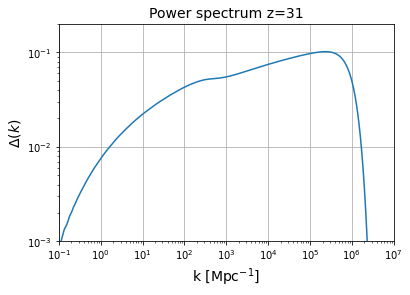

In [3]:
plt.loglog(cuspdis.k, cuspdis.Dk_cdm/(1.+31.)**2)
plt.xlim(1e-1,1e7)
plt.ylim(1e-3, 2e-1)
plt.grid("on")
plt.xlabel(r"k [Mpc$^{-1}$]", fontsize=14)
plt.ylabel(r"$\Delta (k)$", fontsize=14)
plt.title("Power spectrum z=31", fontsize=14)

# Some informative numbers (compare Delos & White 2022, Fig. 1)

In [4]:
sel = cusps["valid"] & (cusps["acoll"] < 1.)
mtot = np.sum(cusps["Mcusp"][sel])
nallpos = len(cusps["Mcusp"])
H0 = 68.7
Gmpc = 43.0071057317063 * 1e-10
rho0 = 3.*H0**2 / (8.*np.pi*Gmpc) * (cuspdis.cosmology["omega_cdm"])

mdm = cusps["mdm_tot"]
print("cusp mass fraction", (mtot/mdm))

print("cusp number per mass", np.sum(sel)/mdm)
print("Jcusps/Mdm", np.sum(cusps["J"][sel])/mdm)
print("fraction valid: %.3f" % np.mean(cusps["valid"]))

cusp mass fraction 0.0360201806859482
cusp number per mass 41231.10975220176
Jcusps/Mdm 0.1855816184347599
fraction valid: 0.468


# Recreate Figure 6 from [Delos & White (2022)](https://arxiv.org/pdf/2209.11237.pdf)

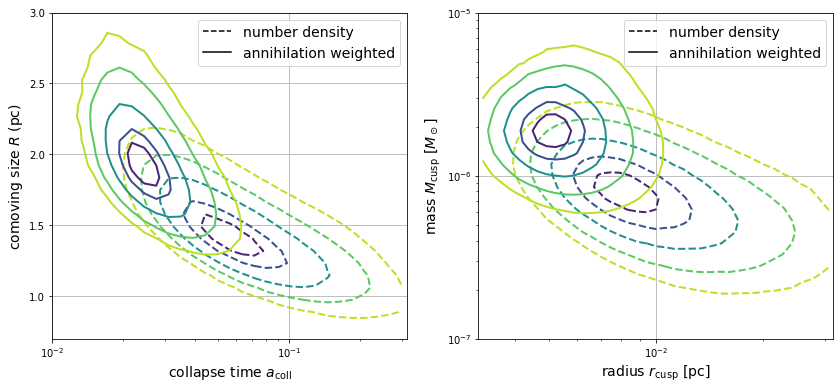

In [5]:
acoll, R, valid, rcusp, Mcusp = cusps["acoll"], cusps["R"], cusps["valid"], cusps["rcusp"], cusps["Mcusp"]
    
fig, axs = plt.subplots(1,2, figsize=(14,6))

bins_acoll = np.logspace(-2,-0.5,30)
bins_R = np.linspace(0.5, 3.,30)
#axs[0].hist2d(acoll[valid], R[valid]*1e6, bins=(bins_acoll, bins_R));
em.plot_contour_hist(acoll[valid], R[valid], ax=axs[0], bins=(bins_acoll, bins_R), logx=True, linestyles="dashed")
em.plot_contour_hist(acoll[valid], R[valid], ax=axs[0], bins=(bins_acoll, bins_R), logx=True, weights=cusps["J"][valid])

bins_rcusp = np.logspace(-2.5, -1.5,40)
bins_Mcusp = np.logspace(-7, -5.,30)
#axs[1].hist2d(rcusp[valid]*1e6, Mcusp[valid], bins=(bins_rcusp, bins_Mcusp));
em.plot_contour_hist(rcusp[valid], Mcusp[valid], ax=axs[1], bins=(bins_rcusp, bins_Mcusp), logx=True, logy=True, linestyles="dashed")
em.plot_contour_hist(rcusp[valid], Mcusp[valid], ax=axs[1], bins=(bins_rcusp, bins_Mcusp), logx=True, logy=True, weights=cusps["J"][valid])

axs[0].set_xlim(bins_acoll[0], bins_acoll[-1])
axs[0].set_ylim(0.7, bins_R[-1])

axs[1].set_xlim(bins_rcusp[0], bins_rcusp[-1])
axs[1].set_ylim(bins_Mcusp[0], bins_Mcusp[-1])

axs[0].set_xlabel(r"collapse time $a_{\rm{coll}}$", fontsize=14)
axs[0].set_ylabel(r"comoving size $R$ (pc)", fontsize=14)

axs[1].set_ylabel(r"mass $M_{\rm{cusp}}$ [$M_\odot$]", fontsize=14)
axs[1].set_xlabel(r"radius $r_{\rm{cusp}}$ [pc]", fontsize=14)

for ax in axs:
    ax.plot([], color="black", linestyle="dashed", label="number density")
    ax.plot([], color="black", linestyle="solid", label="annihilation weighted")
    ax.legend(fontsize=14)
    ax.grid("on")

plt.savefig("img/cusp_distribution.pdf", bbox_inches="tight")

# Other distribution representaitions

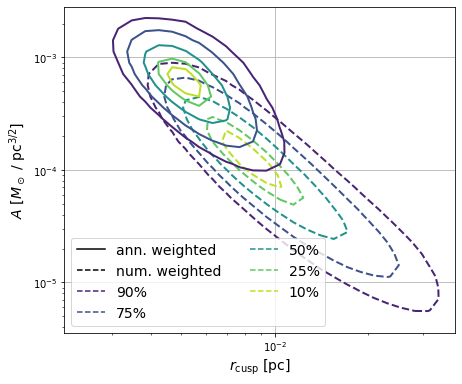

In [6]:
A, rcusp, valid, rcore = cusps["A"], cusps["rcusp"], cusps["valid"], cusps["rcore"]

fig, ax = plt.subplots(1,1, figsize=(7,6))

bins_A = np.logspace(-5.5,-2.5,31)
bins_rcusp = np.logspace(np.log10(2e-3),np.log10(4e-2),31)
#axs[0].hist2d(acoll[valid], R[valid]*1e6, bins=(bins_acoll, bins_R));

ax.plot([], color="black", linestyle="solid", label="ann. weighted")
ax.plot([], color="black", linestyle="dashed", label="num. weighted")

em.plot_contour_hist(rcusp[valid], A[valid], ax=ax, bins=(bins_rcusp, bins_A), logx=True, linestyles="dashed", cmap="viridis", labels=True)
em.plot_contour_hist(rcusp[valid], A[valid], ax=ax, bins=(bins_rcusp, bins_A), logx=True, weights=cusps["J"][valid], cmap="viridis")
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel(r"$r_{\rm{cusp}}$ [pc]", fontsize=14)
ax.set_ylabel(r"$A$ [$M_\odot$ / pc$^{3/2}$]", fontsize=14)


ax.legend(fontsize=14, loc="lower left", ncol=2)
ax.grid("on")

plt.savefig("img/cusp_A_vs_rcusp.pdf", bbox_inches="tight")

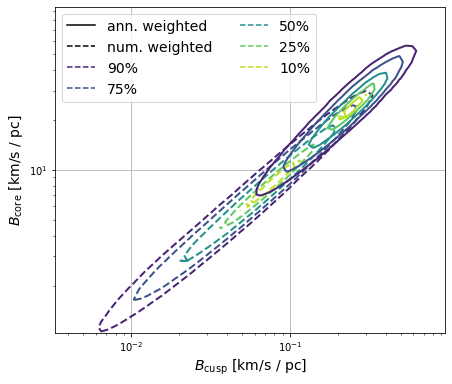

In [7]:
A, rcusp, valid, rcore, Bcore, Bcusp = cusps["A"], cusps["rcusp"], cusps["valid"], cusps["rcore"], cusps["Bcore"], cusps["Bcusp"]

fig, ax = plt.subplots(1,1, figsize=(7,6))

#Bcore =  np.sqrt((8. * np.pi * A * G) / (rcore**(1.5)*3.))
#Bcusp =  np.sqrt((8. * np.pi * A * G) / (rcusp**(1.5)*3.))

bins_Bcusp = np.logspace(-2.5,0,61)
bins_Bcore = np.logspace(np.log10(1e0),np.log10(1e2),61)
#axs[0].hist2d(acoll[valid], R[valid]*1e6, bins=(bins_acoll, bins_R));

ax.plot([], color="black", linestyle="solid", label="ann. weighted")
ax.plot([], color="black", linestyle="dashed", label="num. weighted")

em.plot_contour_hist(Bcusp[valid], Bcore[valid], ax=ax, bins=(bins_Bcusp, bins_Bcore), logx=True, linestyles="dashed", cmap="viridis", labels=True)
em.plot_contour_hist(Bcusp[valid], Bcore[valid], ax=ax, bins=(bins_Bcusp, bins_Bcore), logx=True, weights=cusps["J"][valid], cmap="viridis")
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel(r"$B_{\rm{cusp}}$ [km/s / pc]", fontsize=14)
ax.set_ylabel(r"$B_{\rm{core}}$ [km/s / pc]", fontsize=14)


ax.legend(fontsize=14, loc="upper left", ncol=2)

plt.savefig("img/cusp_Bcusp_vs_Bcore.pdf", bbox_inches="tight")

# What kind of encounters are necessary to reach Bcusp and Bcore?

In [8]:
Bcore, Bcusp = 30., 0.3

Mstar, vstar = 1., 200.

bcore, bcusp = (np.sqrt(2.*Mstar*G / (np.array((Bcore, Bcusp))*vstar)))


import scipy.constants as const
print("%.3e pc, %g AU" % (bcore, bcore*const.parsec/const.au))
print("%.3e pc, %g AU" % (bcusp, bcusp*const.parsec/const.au))

1.197e-03 pc, 246.965 AU
1.197e-02 pc, 2469.65 AU


# Profile of Cored Cusps

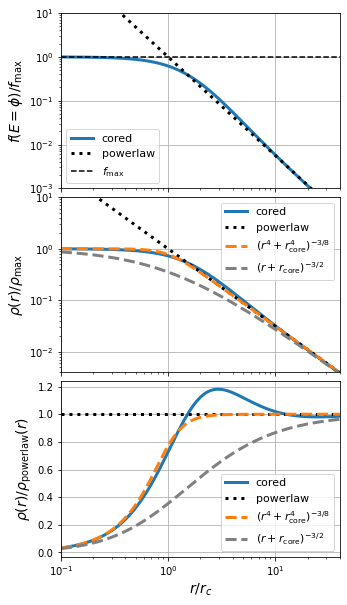

In [9]:
cprof = cusp_encounters.cored_powerlaw.PhasespaceTruncatedCusp(A=1., rcore=1.)

r = np.logspace(-1,2, 200)*cprof.rcore

fig, axs = plt.subplots(3,1, figsize=(5,10), sharex=True)
fig.subplots_adjust(hspace=0.05)

fmax = cprof.fmax
axs[0].loglog(r, cprof.f_of_e(cprof.potential(r))/fmax, lw=3, label="cored")
axs[0].loglog(r, cprof.base_powerlaw.f_of_e(cprof.base_powerlaw.potential(r))/fmax, lw=3, linestyle="dotted", color="black", label="powerlaw")
#axs[0].loglog(r, cprof.base_powerlaw.density(r), linestyle="dashed", color="black", lw=2)
axs[1].loglog(r, cprof.density(r), lw=3, label="cored")
axs[1].loglog(r, cprof.base_powerlaw.density(r), linestyle="dotted", color="black", lw=3, label="powerlaw")
axs[2].semilogx(r, cprof.density(r)/cprof.base_powerlaw.density(r), lw=3, label="cored")
axs[2].axhline(1., linestyle="dotted", color="black", lw=3, label="powerlaw")

def rhoapprox(r):
    return (r**4 + cprof.rcore**4)**(-3./8.)
def rho_badcore(r):
    return (r + cprof.rcore)**(-3./2.)
axs[1].plot(r, rhoapprox(r), linestyle="dashed", lw=3, label=r"$(r^4 + r_{\rm{core}}^4)^{-3/8}$")
axs[2].plot(r, rhoapprox(r)/cprof.base_powerlaw.density(r), linestyle="dashed", lw=3, label=r"$(r^4 + r_{\rm{core}}^4)^{-3/8}$")

axs[0].axhline(1., linestyle="dashed", color="black", label=r"$f_{\rm{max}}$")



axs[0].set_ylabel(r"$f(E = \phi) / f_{\rm{max}}$", fontsize=14)
axs[1].set_ylabel(r"$\rho(r) / \rho_{\rm{max}}$", fontsize=14)
axs[2].set_ylabel(r"$\rho(r) / \rho_{\rm{powerlaw}}(r)$", fontsize=14)

axs[0].set_ylim(1e-3, 1e1)
axs[1].set_ylim(4e-3, 1e1)

for ax in axs:
    ax.legend(fontsize=11)
    ax.grid("on")
    ax.set_xlim(1e-1, 4e1)
axs[-1].set_xlabel(r"$r / r_c$", fontsize=14)

plt.savefig("img/cored_profile.pdf", bbox_inches="tight")
axs[1].plot(r, rho_badcore(r), linestyle="dashed", lw=3, color="grey", label=r"$(r + r_{\rm{core}})^{-3/2}$")
axs[2].plot(r, rho_badcore(r)/cprof.base_powerlaw.density(r), linestyle="dashed", lw=3, color="grey", label=r"$(r + r_{\rm{core}})^{-3/2}$")
for ax in axs:
    ax.legend(fontsize=11)

plt.savefig("img/cored_profile_oldprofile_marked.pdf", bbox_inches="tight")

# How well, does the distant tide approximation work?

We assume, that it works well if $r_B \ll b$ (for the strongest encountered shock), since almost all particles with $r > r_B$ will leave the system.

$$
\begin{align}
r_B &= \left(\frac{8 \pi G A}{3 B^2 }\right)^{2/3} \\
     &= \left( \frac{2 \pi A}{3 G} \right)^{2/3} \frac{b^{8/3} v^{4/3}}{M_* ^{4/3}}
\end{align}
$$

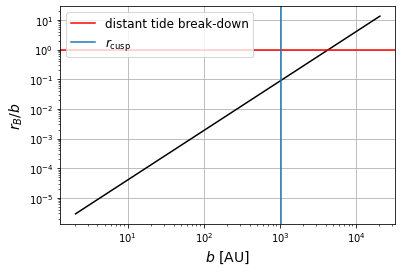

In [10]:
M, v = 1., 200.

A, rcusp = 8e-4, 5e-3
#A, rcusp = 1e-4, 1e-2

b = np.logspace(-5,-1)
rB = (2.*np.pi*A/(3.*G))**(2./3.) * b**(8/3.) * v**(4./3.) / M**(4./3.)


plt.loglog(b * const.parsec / const.au, rB/b, color="black")
plt.xlabel("$b$ [AU]", fontsize=14)
plt.ylabel(r"$r_B / b$", fontsize=14)

plt.axhline(1., color="red", label="distant tide break-down")
plt.axvline(rcusp*const.parsec / const.au, label=r"$r_{\rm{cusp}}$")

plt.grid()
plt.legend(fontsize=12)

For prompt cusps we always have $\rm{min}(r_B, r_{\rm{cusp}}) \ll b$ so that it is always save to assume the distant tide approximation!

However, what about NFW haloes? Can we apply our calculations of the shock distribution to those? Remember that the definition of is so that 
$$
\frac{v_{\rm{circ}(r_B)}}{r_B} = B
$$

Text(0, 0.5, '$r_B / b$')

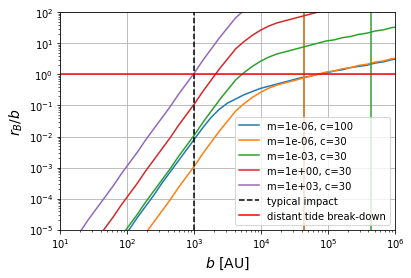

In [11]:
b = np.logspace(-5,1)
B = 2.*G*M/(v*b**2)

for conc, m200c in (100., 1e-6),(30., 1e-6),(30.,1e-3),(30.,1),(30.,1e3):
    nfw = at.profiles.NFWProfile(conc=conc, m200c=m200c)
    r = np.logspace(-20,12,1000) * nfw.r200c
    Bnfw = nfw.vcirc(r)/r
    rB = r[np.argmax(Bnfw/1e6 < B[:,np.newaxis], axis=-1)]

    p = plt.loglog(b*const.parsec / const.au, (rB*1e6)/b, label="m=%.0e, c=%g" % (nfw.m200c, nfw.conc))
    plt.axvline(nfw.r200c*1e6*const.parsec / const.au, color=p[0].get_color())

plt.axvline(1e3, color="black", linestyle="dashed", label="typical impact")
plt.axhline(1., color="red", label="distant tide break-down")
plt.grid()
plt.legend(fontsize=10)
plt.ylim(1e-5,1e2)
plt.xlim(1e1,1e6)

plt.xlabel("$b$ [AU]", fontsize=14)
plt.ylabel(r"$r_B / b$", fontsize=14)

It seems that NFW haloes should also be fine, if we limit ourselves to shocks with impact parameters $b < 1000\rm{AU}$ and haloes with masses $m \lesssim 1 M_\odot$. Weaker shocks will not be reliably described in the distant tide approximation, nor will be higher masses. $10^{-6} M_\odot$ haloes will be fine at any shock strength (and concentration).

Therefore, most of our results can be applied to studies of NFW haloes. However, some additional care must be taken for evaluating that the approximations are valid for those encounters that are relevant: While weak encounters will not necessarily hit all the material in the distant tide regime, it is likely that the inaccurately described material will be removed in other stronger encounters, so that it is overall fine to use the distant tide approximation. Feel free to contact me, for a more detailed explanation